In [1]:
#install.packages('randomForest')
#install.packages('caret')
#install.packages('ranger')
#install.packages('pROC')
#install.packages('boot')

In [2]:
suppressPackageStartupMessages(library(randomForest))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(ranger))
suppressPackageStartupMessages(library(pROC))
suppressPackageStartupMessages(library(boot))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(phyloseq))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(microbiome))

Warning message:
"package 'randomForest' was built under R version 4.5.2"
Warning message:
"package 'caret' was built under R version 4.5.2"
Warning message:
"package 'ggplot2' was built under R version 4.5.2"
Warning message:
"package 'ranger' was built under R version 4.5.2"
Warning message:
"package 'pROC' was built under R version 4.5.2"
Warning message:
"package 'boot' was built under R version 4.5.2"
Warning message:
"package 'readr' was built under R version 4.5.2"
Warning message:
"package 'purrr' was built under R version 4.5.2"
Warning message:
"package 'stringr' was built under R version 4.5.2"


### Data Preprocessing

In [3]:
phyloseq <- readRDS('phyloseq_object.rds')

In [4]:
sig_taxa <- read.csv("significant_taxa.csv", stringsAsFactors = FALSE) |>
    filter(padj < 0.05)

sig_taxa_sorted <- sig_taxa[order(abs(sig_taxa$log2FoldChange), decreasing = TRUE), ]

# Pick top 20 OTUs
top_otus <- sig_taxa_sorted$OTU_ID[1:20]

# Subset OTUs
ps_top <- prune_taxa(top_otus, phyloseq)

# Check dimensions
ps_top

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 91 samples ]
sample_data() Sample Data:       [ 91 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 20 tips and 19 internal nodes ]

In [5]:
ps_clr <- transform(ps_top, "clr")

gut_transformed <- psmelt(ps_clr) |> 
  # Collapse duplicates if needed
  group_by(Sample, Study_Id, Opioid.Substance, Genus) |> 
  summarise(Abundance = mean(Abundance), .groups = "drop") |> 
  # Z-transform each genus
  group_by(Genus) |> 
  mutate(Abundance = scale(Abundance)) |> 
  ungroup() |> 
  pivot_wider(names_from = Genus, values_from = Abundance)

In [6]:
# Remove rows with NA values in the metadata
gut_prepped = gut_transformed |> 
    na.omit() |>
    mutate(Study_Id = as.character(Study_Id)) |>
    filter(Study_Id != '2034') |>
    select(-Sample)

head(gut_prepped)

Study_Id,Opioid.Substance,g__Anaerococcus,g__Bacteroides,g__Campylobacter,g__Dialister,g__Fenollaria,g__Finegoldia,g__Odoribacter,g__Parabacteroides,g__Peptoniphilus,g__Porphyromonas,g__Prevotella,g__Streptococcus,g__Sutterella
<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2048,Yes,-0.19987572,0.2081334,-0.32015838,-0.24070205,-0.26594742,-0.3321146,-0.2201065,0.6727341,-0.18298705,-0.2924657,-0.4731549,-0.2159906,-0.2931882
2049,No,0.99653340,0.8277806,0.07978809,0.95169610,0.04503887,0.4094127,0.1950568,-2.0603049,1.09454686,0.8498761,0.6610899,0.4238452,0.1766836
2051,Yes,-0.84605446,0.3406589,-0.53616886,-0.88471447,-0.43391063,-0.7326123,-0.4443356,0.4770869,-0.87298117,-0.9094427,1.2432357,-0.5615649,-0.5469652
3001,Yes,-0.21801072,0.5283308,-0.32622071,-0.25877626,-0.27066130,-0.3433546,-0.2263995,0.3870650,-0.20235174,-0.3097812,-0.4903476,-0.2256891,-0.3003104
3002,No,-0.03837084,-0.1948148,-0.26616907,-0.07973862,-0.22396696,-0.2320148,-0.1640631,0.7867109,-0.01053103,-0.1382594,-0.3200416,-0.1296183,-0.2297596
3003,No,-0.14437083,0.6224628,-0.30160370,-0.18538324,-0.25151986,-0.2977130,-0.2008459,0.1632758,-0.12371855,-0.2394691,-0.4205340,-0.1863067,-0.2713895


##### Combined data

In [7]:
# read in biomarker data, and keep only significant markers based on wilcoxon rank test
biomarker <- read_excel('Final_Altered_metadata_biomarker.xlsx') |>
    select(Study_Id, FPG, Fasting_insulin, Fasting_Proinsulin, OGIS, AUC_glucose, AUC_insulin, Opioid.Substance) |>
    mutate(Study_Id = as.character(Study_Id)) |>
    tidyr::drop_na()

# prep for merging
biomarker_merge <- biomarker |>
    select(-Opioid.Substance)

# identify overlapping IDs to filter and merge safely
common_ids <- intersect(gut_prepped$Study_Id, biomarker_merge$Study_Id)

biomarker_filtered <- biomarker_merge[biomarker_merge$Study_Id %in% common_ids, ]
gut_filtered <- gut_prepped[gut_prepped$Study_Id %in% common_ids, ]

gut_bio_merged <- inner_join(gut_filtered, biomarker_filtered, by = 'Study_Id')

head(gut_bio_merged)
#write.csv(gut_bio_merged, "gut_bio_merged.csv", row.names=FALSE)

Study_Id,Opioid.Substance,g__Anaerococcus,g__Bacteroides,g__Campylobacter,g__Dialister,g__Fenollaria,g__Finegoldia,g__Odoribacter,g__Parabacteroides,⋯,g__Porphyromonas,g__Prevotella,g__Streptococcus,g__Sutterella,FPG,Fasting_insulin,Fasting_Proinsulin,OGIS,AUC_glucose,AUC_insulin
<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",⋯,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2048,Yes,-0.19987572,0.2081334,-0.32015838,-0.24070205,-0.26594742,-0.3321146,-0.2201065,0.6727341,⋯,-0.2924657,-0.4731549,-0.2159906,-0.2931882,109,7.60,15.4,482,20285,4796
2049,No,0.99653340,0.8277806,0.07978809,0.95169610,0.04503887,0.4094127,0.1950568,-2.0603049,⋯,0.8498761,0.6610899,0.4238452,0.1766836,87,2.18,7.5,482,16175,2856
2051,Yes,-0.84605446,0.3406589,-0.53616886,-0.88471447,-0.43391063,-0.7326123,-0.4443356,0.4770869,⋯,-0.9094427,1.2432357,-0.5615649,-0.5469652,92,5.89,7.5,461,23075,5949
3001,Yes,-0.21801072,0.5283308,-0.32622071,-0.25877626,-0.27066130,-0.3433546,-0.2263995,0.3870650,⋯,-0.3097812,-0.4903476,-0.2256891,-0.3003104,117,24.71,34.7,280,28955,33284
3002,No,-0.03837084,-0.1948148,-0.26616907,-0.07973862,-0.22396696,-0.2320148,-0.1640631,0.7867109,⋯,-0.1382594,-0.3200416,-0.1296183,-0.2297596,103,11.05,16.9,359,21230,23702
3003,No,-0.14437083,0.6224628,-0.30160370,-0.18538324,-0.25151986,-0.2977130,-0.2008459,0.1632758,⋯,-0.2394691,-0.4205340,-0.1863067,-0.2713895,111,27.85,36.0,295,30170,24795


In [ ]:
# prep data for model use by dropping gut microbiome and biomarker columns, respectively
biomarker_final <- gut_bio_merged |>
    select(Study_Id, Opioid.Substance, FPG, Fasting_insulin, Fasting_Proinsulin, OGIS, AUC_glucose, AUC_insulin)
head(biomarker_final)

gut_final <- gut_bio_merged |>
    select(-FPG, -Fasting_insulin, -Fasting_Proinsulin, -OGIS, -AUC_glucose, -AUC_insulin)
head(gut_final)

#write.csv(biomarker_final, "biomarker_final.csv", row.names=FALSE)
#write.csv(gut_final, "gut_final.csv", row.names=FALSE)

Study_Id,Opioid.Substance,FPG,Fasting_insulin,Fasting_Proinsulin,OGIS,AUC_glucose,AUC_insulin
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
2048,Yes,109,7.60,15.4,482,20285,4796
2049,No,87,2.18,7.5,482,16175,2856
2051,Yes,92,5.89,7.5,461,23075,5949
3001,Yes,117,24.71,34.7,280,28955,33284
3002,No,103,11.05,16.9,359,21230,23702
3003,No,111,27.85,36.0,295,30170,24795


Study_Id,Opioid.Substance,g__Anaerococcus,g__Bacteroides,g__Campylobacter,g__Dialister,g__Fenollaria,g__Finegoldia,g__Odoribacter,g__Parabacteroides,g__Peptoniphilus,g__Porphyromonas,g__Prevotella,g__Streptococcus,g__Sutterella
<chr>,<chr>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
2048,Yes,-0.19987572,0.2081334,-0.32015838,-0.24070205,-0.26594742,-0.3321146,-0.2201065,0.6727341,-0.18298705,-0.2924657,-0.4731549,-0.2159906,-0.2931882
2049,No,0.99653340,0.8277806,0.07978809,0.95169610,0.04503887,0.4094127,0.1950568,-2.0603049,1.09454686,0.8498761,0.6610899,0.4238452,0.1766836
2051,Yes,-0.84605446,0.3406589,-0.53616886,-0.88471447,-0.43391063,-0.7326123,-0.4443356,0.4770869,-0.87298117,-0.9094427,1.2432357,-0.5615649,-0.5469652
3001,Yes,-0.21801072,0.5283308,-0.32622071,-0.25877626,-0.27066130,-0.3433546,-0.2263995,0.3870650,-0.20235174,-0.3097812,-0.4903476,-0.2256891,-0.3003104
3002,No,-0.03837084,-0.1948148,-0.26616907,-0.07973862,-0.22396696,-0.2320148,-0.1640631,0.7867109,-0.01053103,-0.1382594,-0.3200416,-0.1296183,-0.2297596
3003,No,-0.14437083,0.6224628,-0.30160370,-0.18538324,-0.25151986,-0.2977130,-0.2008459,0.1632758,-0.12371855,-0.2394691,-0.4205340,-0.1863067,-0.2713895


### Model 1: Microbiome data only

In [9]:
# separate outcome and study id
gut_predictors = gut_final |> 
    select(-Study_Id, -Opioid.Substance)

gut_outcome = gut_final |> 
    pull(Opioid.Substance) |>
    factor(levels = c('No','Yes'))

In [10]:
# RF setup
set.seed(475)
gut_folds = createFolds(gut_outcome, k = 5, list = TRUE)

gut_tune_grid = expand.grid(
    mtry = c(2, 3, 4, 5, 6), 
    splitrule = c("gini","extratrees"),
    min.node.size = c(1, 2, 3, 4, 5)
    )

In [11]:
# run RF
source('randomforest_functions.R')

gut_model = run_rf(
    X = gut_predictors, 
    y = gut_outcome, 
    fold_list = gut_folds,
    hyper = gut_tune_grid, 
    rngseed = 475
    )

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

`summarise()` has grouped output by 'row'. You can override using the `.groups`
argument.


Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


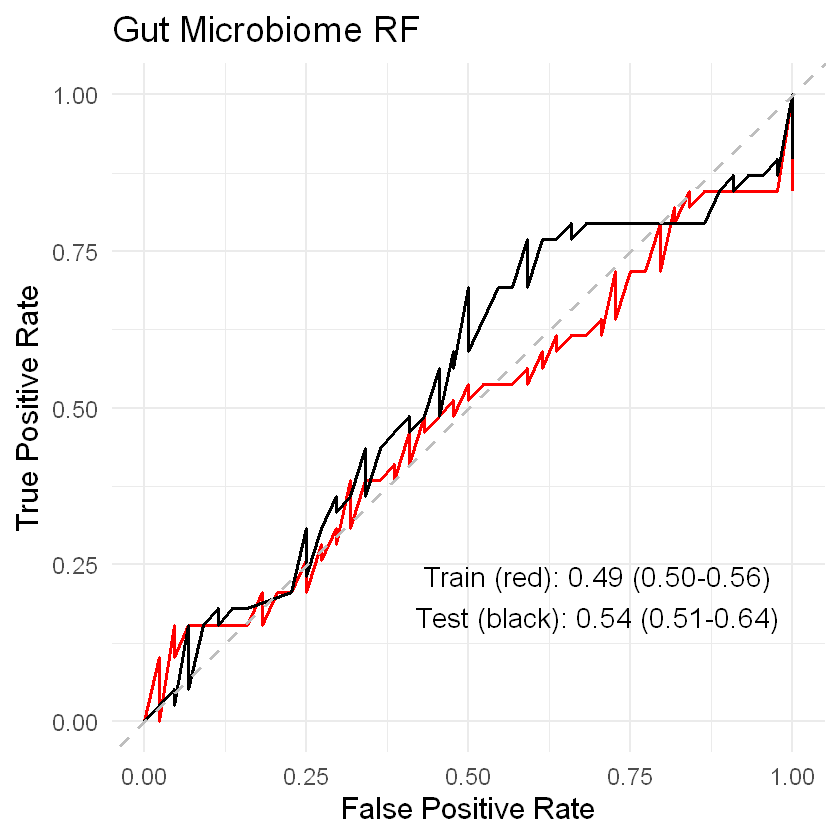

In [12]:
gut_roc_test = roc(gut_model$test_labels$true_labels,
               gut_model$test_labels$predicted_probabilities)
gut_roc_train = roc(gut_model$train_labels$true_labels,
                gut_model$train_labels$predicted_probabilities)

# True positive rate = sensitivity
# False positive rate = 1-specificity
gut_auc_plot <- ggplot() +
  # Training data: this is a type of control
  geom_line(aes(x = 1 - gut_roc_train$specificities, 
                y = gut_roc_train$sensitivities), 
            color = "red",size=1) +
  # Test data: tells us the strength of the prediction
  geom_line(aes(x = 1 - gut_roc_test$specificities,
                y = gut_roc_test$sensitivities), 
            color = "black",size=1) +
  geom_abline(slope = 1, intercept = 0, color = "gray", linetype = "dashed",size=1) +
  labs(x = "False Positive Rate", y = "True Positive Rate", title = 'Gut Microbiome RF') +
  annotate("text", x = 0.7, y = 0.2, 
           label = sprintf("Train (red): %.2f (%.2f-%.2f)\nTest (black): %.2f (%.2f-%.2f)",
           auc(gut_roc_train), gut_model$auc_train_ci[1], gut_model$auc_train_ci[2],
           auc(gut_roc_test), gut_model$auc_test_ci[1], gut_model$auc_test_ci[2]), 
           size = 6) +
  theme_minimal(base_size=18)
gut_auc_plot

In [13]:
gut_roc_data = data.frame(Dataset = 'Gut Microbiome RF',
     Training_AUC = round(gut_model$auc_train, 2),
     Training_AUC_CI = paste0(round(gut_model$auc_train_ci[1], 2), "-", 
                              round(gut_model$auc_train_ci[2], 2)),
     Testing_AUC = round(gut_model$auc_test, 2),
     Testing_AUC_CI = paste0(round(gut_model$auc_test_ci[1], 2), "-", 
                             round(gut_model$auc_test_ci[2], 2)))

gut_roc_data

Dataset,Training_AUC,Training_AUC_CI,Testing_AUC,Testing_AUC_CI
<chr>,<dbl>,<chr>,<dbl>,<chr>
Gut Microbiome RF,0.53,0.5-0.56,0.57,0.51-0.64


### Model 2: Biomarker data only

In [14]:
# separate outcome and study id
bio_predictors = biomarker_final |> 
    select(-Study_Id, -Opioid.Substance)

bio_outcome = biomarker_final |> 
    pull(Opioid.Substance) |>
    factor(levels = c('No','Yes'))

In [15]:
# RF setup
set.seed(475)
bio_folds = createFolds(bio_outcome, k = 5, list = TRUE)

bio_tune_grid = expand.grid(
    mtry = c(1, 2, 3, 4, 5, 6), 
    splitrule = c("gini","extratrees"),
    min.node.size = c(1, 2, 3)
    )

In [16]:
# run RF
source('randomforest_functions.R')

bio_model = run_rf(
    X = bio_predictors, 
    y = bio_outcome, 
    fold_list = bio_folds,
    hyper = bio_tune_grid, 
    rngseed = 475
    )

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

`summarise()` has grouped output by 'row'. You can override using the `.groups`
argument.


Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases



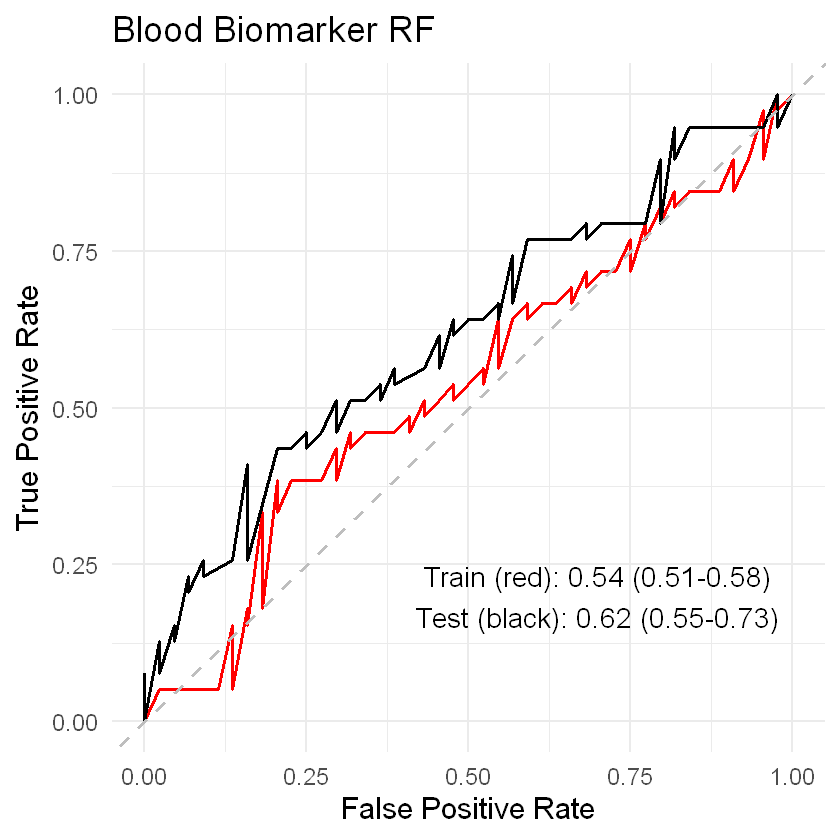

In [17]:
bio_roc_test = roc(bio_model$test_labels$true_labels,
               bio_model$test_labels$predicted_probabilities)
bio_roc_train = roc(bio_model$train_labels$true_labels,
                bio_model$train_labels$predicted_probabilities)

# True positive rate = sensitivity
# False positive rate = 1-specificity
bio_auc_plot <- ggplot() +
  # Training data: this is a type of control
  geom_line(aes(x = 1 - bio_roc_train$specificities, 
                y = bio_roc_train$sensitivities), 
            color = "red",size=1) +
  # Test data: tells us the strength of the prediction
  geom_line(aes(x = 1 - bio_roc_test$specificities,
                y = bio_roc_test$sensitivities), 
            color = "black",size=1) +
  geom_abline(slope = 1, intercept = 0, color = "gray", linetype = "dashed",size=1) +
  labs(x = "False Positive Rate", y = "True Positive Rate", title = 'Blood Biomarker RF') +
  annotate("text", x = 0.7, y = 0.2, 
           label = sprintf("Train (red): %.2f (%.2f-%.2f)\nTest (black): %.2f (%.2f-%.2f)",
           auc(bio_roc_train), bio_model$auc_train_ci[1], bio_model$auc_train_ci[2],
           auc(bio_roc_test), bio_model$auc_test_ci[1], bio_model$auc_test_ci[2]), 
           size = 6) +
  theme_minimal(base_size=18)
bio_auc_plot

In [18]:
bio_roc_data = data.frame(Dataset = 'Biomarker RF',
     Training_AUC = round(bio_model$auc_train, 2),
     Training_AUC_CI = paste0(round(bio_model$auc_train_ci[1], 2), "-", 
                              round(bio_model$auc_train_ci[2], 2)),
     Testing_AUC = round(bio_model$auc_test, 2),
     Testing_AUC_CI = paste0(round(bio_model$auc_test_ci[1], 2), "-", 
                             round(bio_model$auc_test_ci[2], 2)))

bio_roc_data

Dataset,Training_AUC,Training_AUC_CI,Testing_AUC,Testing_AUC_CI
<chr>,<dbl>,<chr>,<dbl>,<chr>
Biomarker RF,0.54,0.51-0.58,0.64,0.55-0.73


### Model 3: Combined model

In [19]:
# separate outcome and study id
gut_bio_predictors = gut_bio_merged |> 
    select(-Study_Id, -Opioid.Substance)

gut_bio_outcome = gut_bio_merged |> 
    pull(Opioid.Substance) |>
    factor(levels = c('No','Yes'))

In [20]:
# RF setup
set.seed(475)
gut_bio_folds = createFolds(gut_outcome, k = 5, list = TRUE)

gut_bio_tune_grid = expand.grid(
    mtry = c(3, 4, 5, 6, 7, 8), 
    splitrule = c("gini","extratrees"),
    min.node.size = c(1, 2, 3, 4, 5)
    )

In [21]:
# run RF
source('randomforest_functions.R')

gut_bio_model = run_rf(
    X = gut_bio_predictors, 
    y = gut_bio_outcome, 
    fold_list = gut_bio_folds,
    hyper = gut_bio_tune_grid, 
    rngseed = 475
    )

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls > cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases

`summarise()` has grouped output by 'row'. You can override using the `.groups`
argument.


Setting levels: control = No, case = Yes

Setting direction: controls < cases

Setting levels: control = No, case = Yes

Setting direction: controls < cases



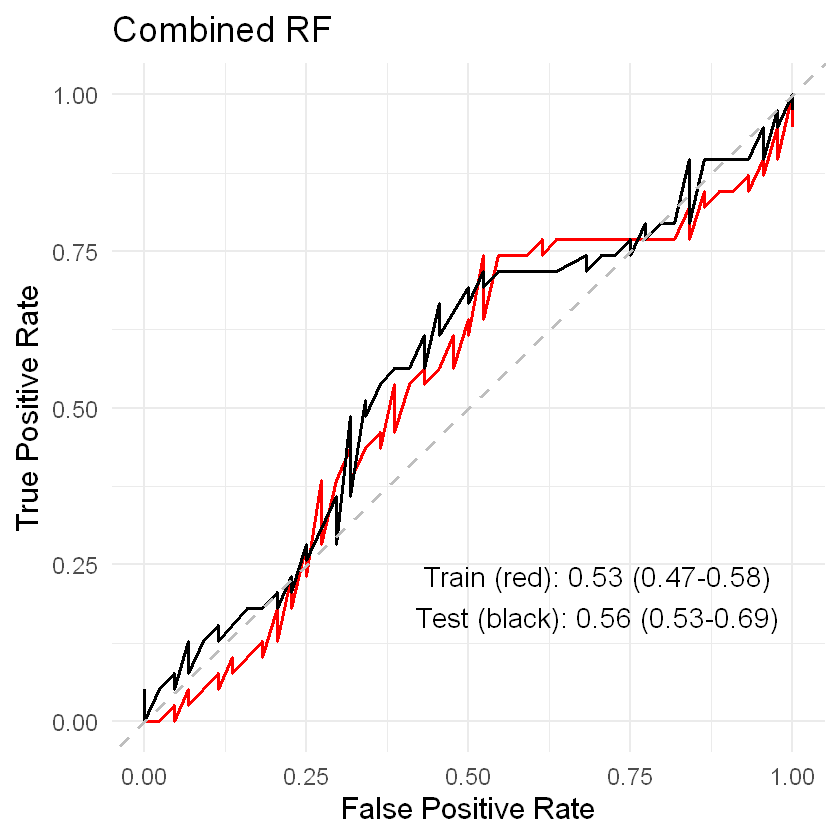

In [22]:
gut_bio_roc_test = roc(gut_bio_model$test_labels$true_labels,
               gut_bio_model$test_labels$predicted_probabilities)
gut_bio_roc_train = roc(gut_bio_model$train_labels$true_labels,
                gut_bio_model$train_labels$predicted_probabilities)

# True positive rate = sensitivity
# False positive rate = 1-specificity
gut_bio_auc_plot <- ggplot() +
  # Training data: this is a type of control
  geom_line(aes(x = 1 - gut_bio_roc_train$specificities, 
                y = gut_bio_roc_train$sensitivities), 
            color = "red",size=1) +
  # Test data: tells us the strength of the prediction
  geom_line(aes(x = 1 - gut_bio_roc_test$specificities,
                y = gut_bio_roc_test$sensitivities), 
            color = "black",size=1) +
  geom_abline(slope = 1, intercept = 0, color = "gray", linetype = "dashed",size=1) +
  labs(x = "False Positive Rate", y = "True Positive Rate", title = 'Combined RF') +
  annotate("text", x = 0.7, y = 0.2, 
           label = sprintf("Train (red): %.2f (%.2f-%.2f)\nTest (black): %.2f (%.2f-%.2f)",
           auc(gut_bio_roc_train), gut_bio_model$auc_train_ci[1], gut_bio_model$auc_train_ci[2],
           auc(gut_bio_roc_test), gut_bio_model$auc_test_ci[1], gut_bio_model$auc_test_ci[2]), 
           size = 6) +
  theme_minimal(base_size=18)
gut_bio_auc_plot

In [23]:
gut_bio_roc_data = data.frame(Dataset = 'Combined RF',
     Training_AUC = round(gut_bio_model$auc_train, 2),
     Training_AUC_CI = paste0(round(gut_bio_model$auc_train_ci[1], 2), "-", 
                              round(gut_bio_model$auc_train_ci[2], 2)),
     Testing_AUC = round(gut_bio_model$auc_test, 2),
     Testing_AUC_CI = paste0(round(gut_bio_model$auc_test_ci[1], 2), "-", 
                             round(gut_bio_model$auc_test_ci[2], 2)))

gut_bio_roc_data

Dataset,Training_AUC,Training_AUC_CI,Testing_AUC,Testing_AUC_CI
<chr>,<dbl>,<chr>,<dbl>,<chr>
Combined RF,0.52,0.47-0.58,0.61,0.53-0.69


In [24]:
final_roc_table <- bind_rows(
    gut_roc_data,
    bio_roc_data,
    gut_bio_roc_data
)
final_roc_table

Dataset,Training_AUC,Training_AUC_CI,Testing_AUC,Testing_AUC_CI
<chr>,<dbl>,<chr>,<dbl>,<chr>
Gut Microbiome RF,0.53,0.5-0.56,0.57,0.51-0.64
Biomarker RF,0.54,0.51-0.58,0.64,0.55-0.73
Combined RF,0.52,0.47-0.58,0.61,0.53-0.69


In [25]:
ggsave('bio_auc_plot.png', bio_auc_plot, width = 6, height = 6)
ggsave('gut_auc_plot.png', gut_auc_plot, width = 6, height = 6)
ggsave('gut_bio_auc_plot.png', gut_bio_auc_plot, width = 6, height = 6)